In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fastjet as fj
import pathlib
import subprocess
import vector
import h5py

vector.register_awkward()

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# This loads the file copied from https://github.com/DebajyotiS/PC-JeDi/blob/EPiC-JeDi/src/jet_substructure.py#L459
from jet_substructure import dump_hlvs

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


# Downloading the Top Tagging Reference dataset

In [2]:
dataset_path = pathlib.Path("/beegfs/desy/user/birkjosc/testing/d2_calc")  # CHANGE THIS TO YOUR OWN PATH IF YOU WANT TO RUN THIS
dataset_path.mkdir(parents=True, exist_ok=True)
subprocess.run(["wget", "https://hqu.web.cern.ch/datasets/TopLandscape/TopLandscape.tar"], cwd=dataset_path)
subprocess.run(["tar", "-xf", f"TopLandscape.tar"], cwd=dataset_path)

--2023-10-05 14:52:55--  https://hqu.web.cern.ch/datasets/TopLandscape/TopLandscape.tar
Resolving hqu.web.cern.ch (hqu.web.cern.ch)... 188.185.5.88, 137.138.124.182, 188.185.18.46, ...
Connecting to hqu.web.cern.ch (hqu.web.cern.ch)|188.185.5.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2464307200 (2.3G) [application/x-tar]
Saving to: ‘TopLandscape.tar.5’

     0K .......... .......... .......... .......... ..........  0% 1.92M 20m22s
    50K .......... .......... .......... .......... ..........  0% 1.90M 20m29s
   100K .......... .......... .......... .......... ..........  0%  319M 13m42s
   150K .......... .......... .......... .......... ..........  0% 6.64M 11m45s
   200K .......... .......... .......... .......... ..........  0% 2.66M 12m21s
   250K .......... .......... .......... .......... ..........  0%  416M 10m18s
   300K .......... .......... .......... .......... ..........  0%  499M 8m50s
   350K .......... .......... .......... .........

CompletedProcess(args=['tar', '-xf', 'TopLandscape.tar'], returncode=0)

In [3]:
df = pd.read_parquet(dataset_path / "TopLandscape" / "test_file.parquet")
df = df[:10_000]
df.columns

Index(['label', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'jet_mass',
       'jet_nparticles', 'part_px', 'part_py', 'part_pz', 'part_energy',
       'part_deta', 'part_dphi'],
      dtype='object')

In [4]:
jet_constituents = ak.zip(
    {
        "px": df["part_px"],
        "py": df["part_py"],
        "pz": df["part_pz"],
        "E": df["part_energy"],
    },
    with_name="Momentum4D",
)
is_top = df["label"] == 1

R = 0.8
jetdef = fj.JetDefinition(fj.kt_algorithm, R)
cluster = fj.ClusterSequence(jet_constituents, jetdef)
inclusive_jets = cluster.inclusive_jets()

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


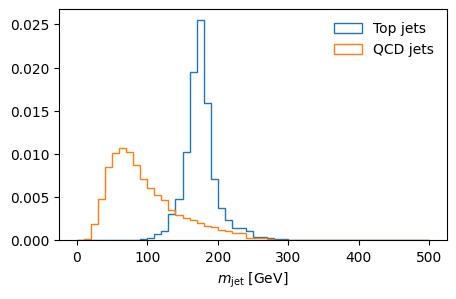

In [5]:
# quick cross-check plot of jet mass
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
hist_kwargs = dict(bins=50, range=(0, 500), histtype="step", density=True)
ax.hist(inclusive_jets[is_top, 0].mass, **hist_kwargs, label="Top jets")
ax.hist(inclusive_jets[~is_top, 0].mass, **hist_kwargs, label="QCD jets")
ax.set_xlabel("$m_{\\mathrm{jet}}$ [GeV]")
ax.legend(frameon=False)

In [6]:
# pad the jet constituents to a fixed size
max_n_constituents = ak.max(ak.num(jet_constituents))
jet_constituents_etaptphi_padded = np.stack(
    [
        ak.to_numpy(ak.fill_none(ak.pad_none(jet_constituents.eta, 128), 0)),
        ak.to_numpy(ak.fill_none(ak.pad_none(jet_constituents.phi, 128), 0)),
        ak.to_numpy(ak.fill_none(ak.pad_none(jet_constituents.pt, 128), 0)),
        ak.to_numpy(ak.fill_none(ak.pad_none(jet_constituents.mass, 128), 0)),
    ],
    axis=-1,
)

In [7]:
# calculate the substructure variables
dump_hlvs(
    jet_constituents_etaptphi_padded,
    dataset_path / "substructure_dump_hlvs.h5",
    R=R,
)

Computing substructure variables: 100%|██████████| 10000/10000 [00:59<00:00, 168.98it/s]


# Comparison of the $D_2$ values for the different calculations

1. As it is in the [PC-JeDi repo](https://github.com/DebajyotiS/PC-JeDi/blob/EPiC-JeDi/src/jet_substructure.py#L459) with `d2 = (ecf3 * sum_pt) / (ecf2**2)`
2. `fastjet` calculation using the `exclusive_jets_energy_correlator` method
3. Modified version from the PC-JeDi repo, using `d2 = ecf3 / (ecf2**3)`

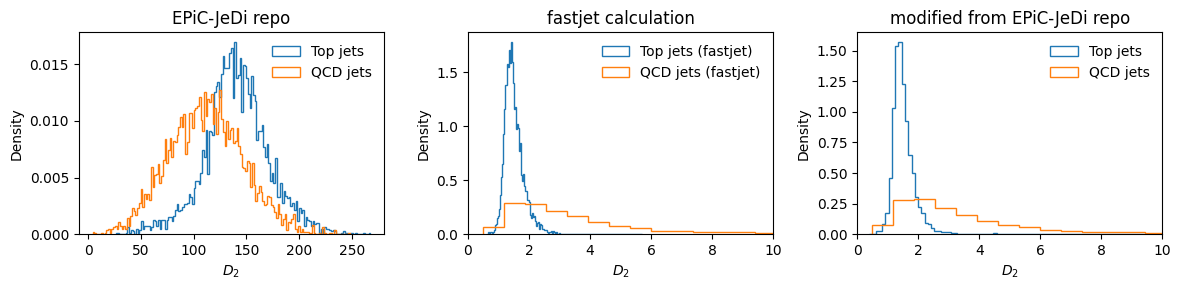

In [8]:
# load the d2 values from the file that was created by dump_hlvs
with h5py.File(dataset_path / "substructure_dump_hlvs.h5", mode="r") as file:
    d2 = file["d2"][:]
    d2_modified = file["d2_modified"][:]
    
# calculate the d2 values using fastjet
d2_fastjet = cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

# plot the d2 values of all three cases:
# 1. calculated with the EPiC-JeDi repo
# 2. calculated with fastjet
# 3. calculated with the EPiC-JeDi repo, but with the modified calculation
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
hist_kwargs = dict(bins=150, histtype="step", density=True)
ax[0].hist(d2[is_top], **hist_kwargs, label="Top jets", color="C0")
ax[0].hist(d2[~is_top], **hist_kwargs, label="QCD jets", color="C1")
ax[1].hist(d2_fastjet[is_top], **hist_kwargs, label="Top jets (fastjet)", linestyle="-", color="C0")
ax[1].hist(d2_fastjet[~is_top], **hist_kwargs, label="QCD jets (fastjet)", linestyle="-", color="C1")
ax[1].set_xlim(0, 10)
ax[2].hist(d2_modified[is_top], **hist_kwargs, label="Top jets", color="C0")
ax[2].hist(d2_modified[~is_top], **hist_kwargs, label="QCD jets", color="C1")
ax[2].set_xlim(0, 10)
ax[0].set_title("EPiC-JeDi repo")
ax[1].set_title("fastjet calculation")
ax[2].set_title("modified from EPiC-JeDi repo")
for a in ax:
    a.set_xlabel("$D_2$")
    a.legend(frameon=False)
    a.set_ylabel("Density")
fig.tight_layout()